In [1]:
from data.dataset_loader import load_bcw_dataset
from tree.DecisionTree import DecisionTree
from utils.plot_tree import plot_tree
from utils.full_evaluation import run_full_evaluation
from utils.metrics import compute_metrics
from utils.plotting import (
    plot_train_val_accuracy,
    plot_tree_complexity,
    plot_overfitting,
)
from utils.analysis import hyperparameter_tuning
from utils.evaluate_tree import evaluate_tree
from utils.feature_importance import compute_feature_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ensembles.randomForest import RandomForest

In [2]:
# Load dataset
(X_train, y_train, X_val, y_val, X_test, y_test, feature_names, target_names) = (
    load_bcw_dataset()
)

# Dataset Summary
print(f"Train size      : {len(X_train)} samples")
print(f"Validation size : {len(X_val)} samples")
print(f"Test size       : {len(X_test)} samples")
print()
print(f"Number of features : {len(feature_names)}")
print(f"Feature names      : {list(feature_names)}")
print(f"Target classes     : {list(target_names)}")

Train size      : 397 samples
Validation size : 86 samples
Test size       : 86 samples

Number of features : 30
Feature names      : [np.str_('mean radius'), np.str_('mean texture'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('mean smoothness'), np.str_('mean compactness'), np.str_('mean concavity'), np.str_('mean concave points'), np.str_('mean symmetry'), np.str_('mean fractal dimension'), np.str_('radius error'), np.str_('texture error'), np.str_('perimeter error'), np.str_('area error'), np.str_('smoothness error'), np.str_('compactness error'), np.str_('concavity error'), np.str_('concave points error'), np.str_('symmetry error'), np.str_('fractal dimension error'), np.str_('worst radius'), np.str_('worst texture'), np.str_('worst perimeter'), np.str_('worst area'), np.str_('worst smoothness'), np.str_('worst compactness'), np.str_('worst concavity'), np.str_('worst concave points'), np.str_('worst symmetry'), np.str_('worst fractal dimension')]
Target classes     :

In [ ]:
# Initialize the tree
tree = DecisionTree(max_depth=6, min_samples_split=5)

# Train on training set
tree.fit(X_train, y_train)

# Plot the tree
target_classes = ["malignant", "benign"]  # 0 -> malignant, 1 -> benign
tree.plot(feature_names=feature_names, class_names=target_classes)
print("Decision tree plot saved as 'tree_output.png'")

Decision tree plot saved as 'tree_output.png'


In [5]:
# Hyperparameter tuning
max_depth_values = [2, 4, 6, 8, 10]
min_samples_split_values = [2, 5, 10]

results_df, models = hyperparameter_tuning(
    X_train,
    y_train,
    X_val,
    y_val,
    max_depth_values,
    min_samples_split_values,
)
print("Hyperparameter tuning results:")
print(results_df)

# Pick best hyperparameters (highest validation accuracy)
best_row = results_df.loc[results_df["val_acc"].idxmax()]
best_max_depth = int(best_row["max_depth"])
best_min_samples_split = int(best_row["min_samples_split"])
print("Best hyperparameters:", best_max_depth, best_min_samples_split)

Hyperparameter tuning results:
    max_depth  min_samples_split  train_acc   val_acc
0           2                  2   0.926952  0.930233
1           2                  5   0.926952  0.930233
2           2                 10   0.926952  0.930233
3           4                  2   0.987406  0.965116
4           4                  5   0.982368  0.953488
5           4                 10   0.977330  0.965116
6           6                  2   1.000000  0.965116
7           6                  5   0.992443  0.953488
8           6                 10   0.982368  0.965116
9           8                  2   1.000000  0.965116
10          8                  5   0.992443  0.953488
11          8                 10   0.982368  0.965116
12         10                  2   1.000000  0.965116
13         10                  5   0.992443  0.953488
14         10                 10   0.982368  0.965116
Best hyperparameters: 4 2


Best decision tree plot saved as 'best_tree_output.png'
Test Set Performance

Overall Accuracy: 0.9419

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.864865  1.000000  0.927536
benign      1.000000  0.907407  0.951456


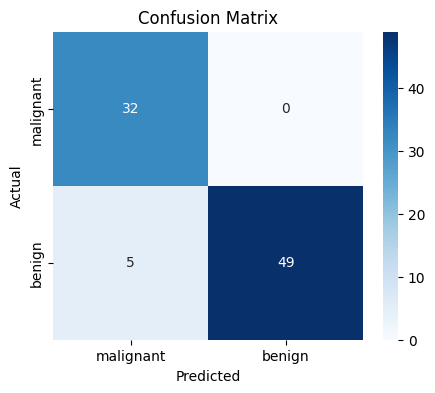

In [ ]:
# Retrain on train + validation
X_train_val = np.vstack([X_train, X_val])
y_train_val = np.hstack([y_train, y_val])
best_tree = DecisionTree(
    max_depth=best_max_depth, min_samples_split=best_min_samples_split
)
best_tree.fit(X_train_val, y_train_val)
best_tree.plot(
    feature_names=feature_names, class_names=target_classes, filename="best_tree_output"
)
print("Best decision tree plot saved as 'best_tree_output.png'")

# Evaluate on test
test_preds = best_tree.predict(X_test)
metrics = compute_metrics(y_test, test_preds, class_names=target_classes)
metrics = evaluate_tree(best_tree, X_test, y_test, class_names=target_classes)


Accuracy Summary (min_samples_split=2)
 Max Depth |  Train Accuracy |  Validation Accuracy
--------------------------------------------------
         2 |          92.70% |               93.02%
         4 |          98.74% |               96.51%
         6 |         100.00% |               96.51%
         8 |         100.00% |               96.51%
        10 |         100.00% |               96.51%


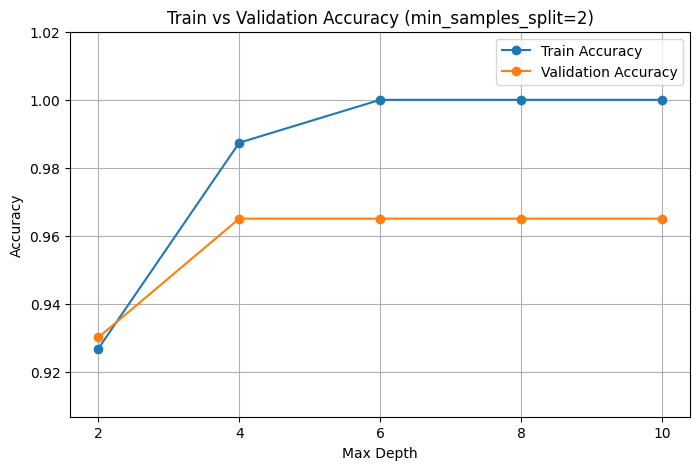

In [9]:
# Plot train vs validation accuracy for fixed min_samples_split
plot_train_val_accuracy(results_df, min_samples_split_fixed=best_min_samples_split)

In [ ]:
# Feature importance
print("Feature Importances:")
feature_importances = compute_feature_importance(best_tree, feature_names=feature_names)

Feature Importances:
                Feature  Importance
7   mean concave points    1.000000
0          worst radius    0.566302
5          mean texture    0.510487
4      mean compactness    0.407468
6      worst smoothness    0.383684
1  worst concave points    0.225413
2            area error    0.031807
3         worst texture    0.021552
                Feature  Importance
7   mean concave points    1.000000
0          worst radius    0.566302
5          mean texture    0.510487
4      mean compactness    0.407468
6      worst smoothness    0.383684
1  worst concave points    0.225413
2            area error    0.031807
3         worst texture    0.021552


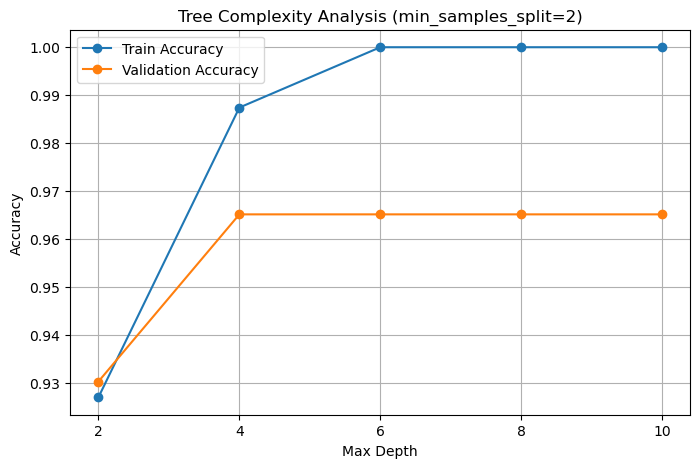


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.987406 0.965116
         6   1.000000 0.965116
         8   1.000000 0.965116
        10   1.000000 0.965116


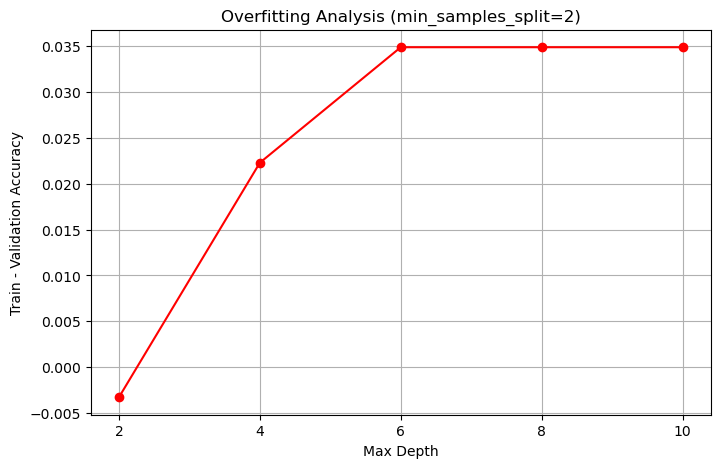


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.987406 0.965116  0.022289
         6   1.000000 0.965116  0.034884
         8   1.000000 0.965116  0.034884
        10   1.000000 0.965116  0.034884


In [ ]:
plot_tree_complexity(results_df, best_min_samples_split)
plot_overfitting(results_df, best_min_samples_split)


================ FULL EVALUATION FOR ALL MODELS ================


-------------------------------------------------------------
 MODEL: max_depth=2, min_samples_split=2
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.9186

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.903226  0.875000  0.888889
benign      0.927273  0.944444  0.935780


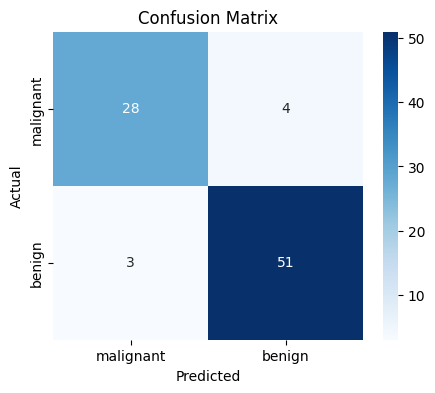



================ FEATURE IMPORTANCE ================

                Feature  Importance
0       worst perimeter    0.557041
1  worst concave points    0.371103


================ TREE COMPLEXITY ANALYSIS ================



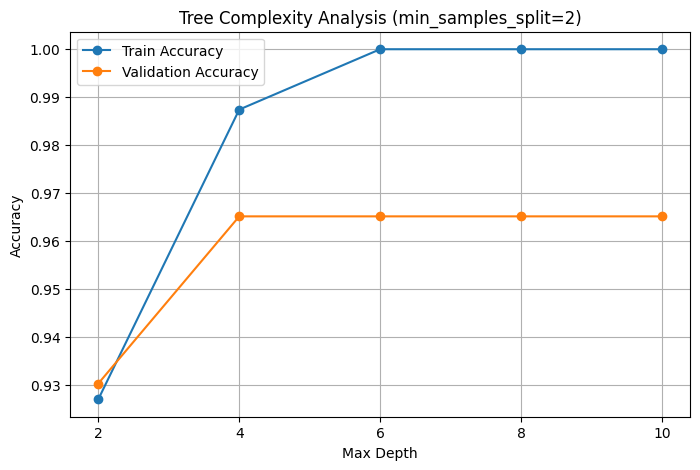


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.987406 0.965116
         6   1.000000 0.965116
         8   1.000000 0.965116
        10   1.000000 0.965116


================ OVERFITTING ANALYSIS ================



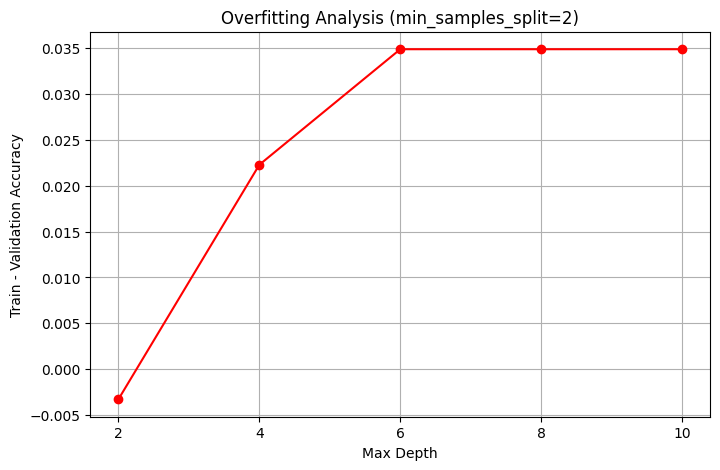


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.987406 0.965116  0.022289
         6   1.000000 0.965116  0.034884
         8   1.000000 0.965116  0.034884
        10   1.000000 0.965116  0.034884

-------------------------------------------------------------
 MODEL: max_depth=2, min_samples_split=5
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.9186

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.903226  0.875000  0.888889
benign      0.927273  0.944444  0.935780


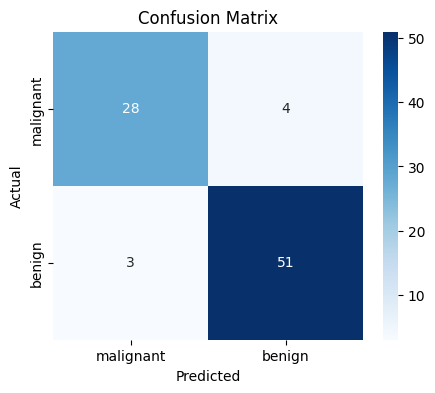



================ FEATURE IMPORTANCE ================

                Feature  Importance
0       worst perimeter    0.557041
1  worst concave points    0.371103


================ TREE COMPLEXITY ANALYSIS ================



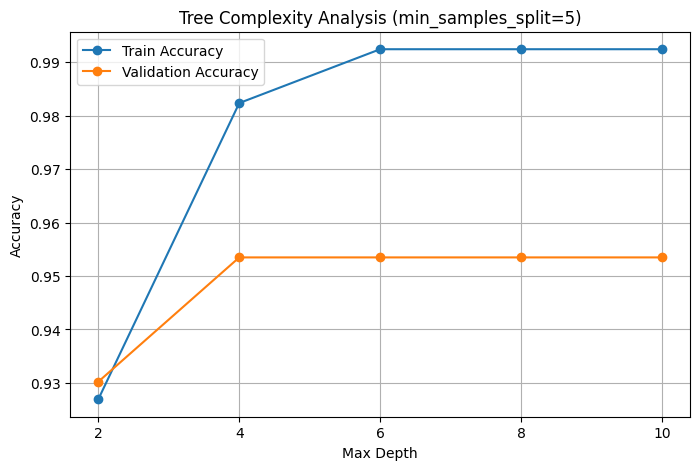


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.982368 0.953488
         6   0.992443 0.953488
         8   0.992443 0.953488
        10   0.992443 0.953488


================ OVERFITTING ANALYSIS ================



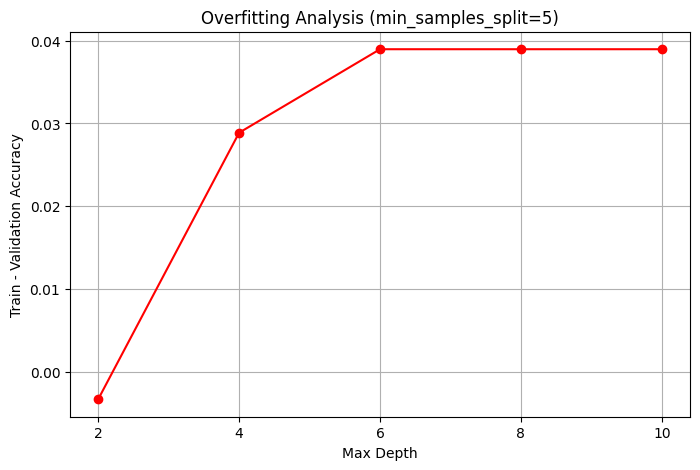


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.982368 0.953488  0.028879
         6   0.992443 0.953488  0.038955
         8   0.992443 0.953488  0.038955
        10   0.992443 0.953488  0.038955

-------------------------------------------------------------
 MODEL: max_depth=2, min_samples_split=10
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.9186

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.903226  0.875000  0.888889
benign      0.927273  0.944444  0.935780


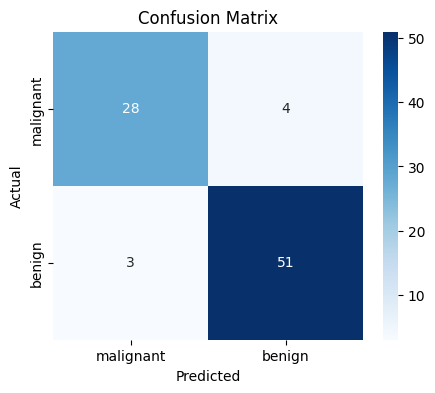



================ FEATURE IMPORTANCE ================

                Feature  Importance
0       worst perimeter    0.557041
1  worst concave points    0.371103


================ TREE COMPLEXITY ANALYSIS ================



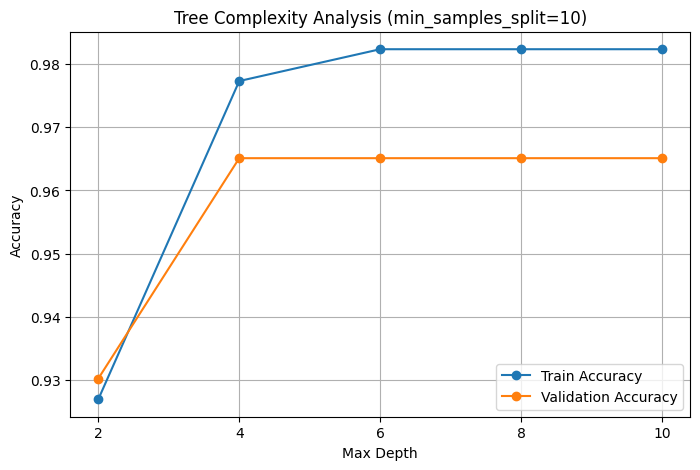


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.977330 0.965116
         6   0.982368 0.965116
         8   0.982368 0.965116
        10   0.982368 0.965116


================ OVERFITTING ANALYSIS ================



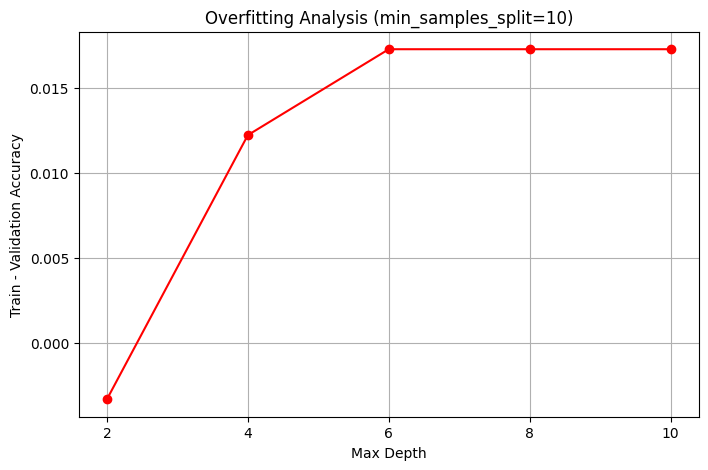


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.977330 0.965116  0.012214
         6   0.982368 0.965116  0.017251
         8   0.982368 0.965116  0.017251
        10   0.982368 0.965116  0.017251

-------------------------------------------------------------
 MODEL: max_depth=4, min_samples_split=2
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.8953

Per-class Metrics:
           Precision   Recall  F1-score
malignant   0.810811  0.93750  0.869565
benign      0.959184  0.87037  0.912621


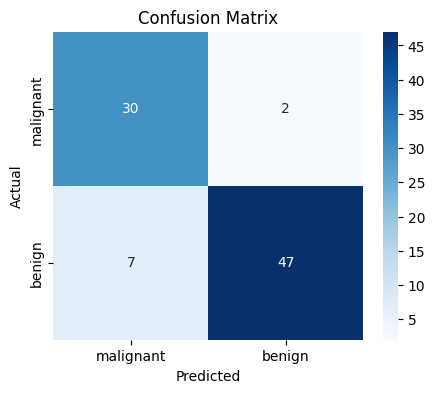



================ FEATURE IMPORTANCE ================

                   Feature  Importance
4         mean compactness    1.000000
7              mean radius    0.764205
0          worst perimeter    0.557041
5             worst radius    0.406431
3            worst texture    0.384667
1     worst concave points    0.371103
6  fractal dimension error    0.340467
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



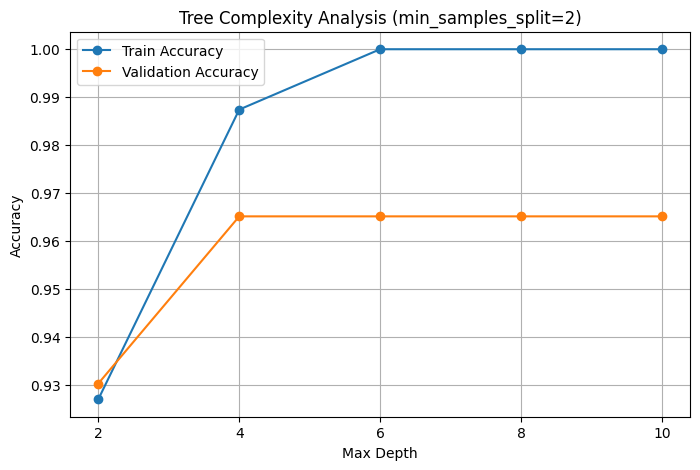


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.987406 0.965116
         6   1.000000 0.965116
         8   1.000000 0.965116
        10   1.000000 0.965116


================ OVERFITTING ANALYSIS ================



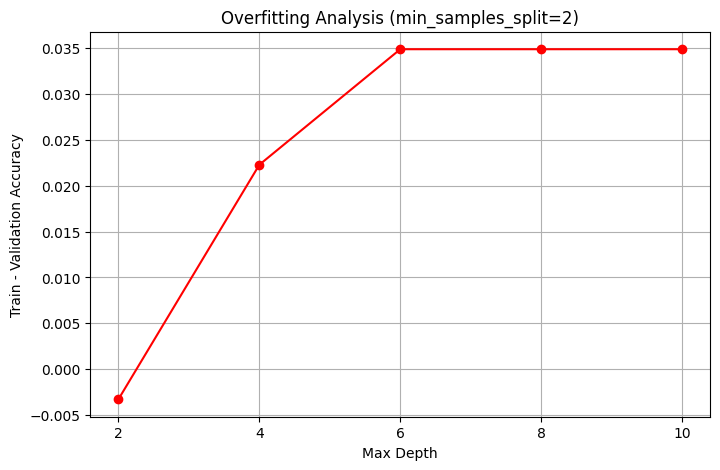


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.987406 0.965116  0.022289
         6   1.000000 0.965116  0.034884
         8   1.000000 0.965116  0.034884
        10   1.000000 0.965116  0.034884

-------------------------------------------------------------
 MODEL: max_depth=4, min_samples_split=5
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.8953

Per-class Metrics:
           Precision   Recall  F1-score
malignant   0.810811  0.93750  0.869565
benign      0.959184  0.87037  0.912621


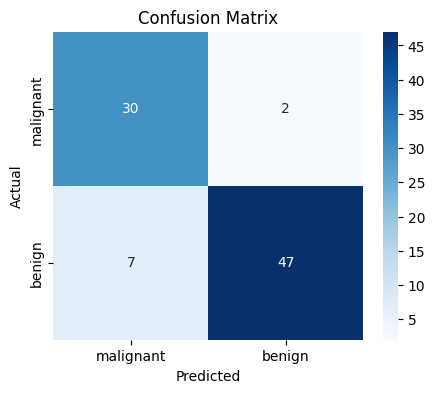



================ FEATURE IMPORTANCE ================

                   Feature  Importance
6              mean radius    0.764205
0          worst perimeter    0.557041
4             worst radius    0.406431
3            worst texture    0.384667
1     worst concave points    0.371103
5  fractal dimension error    0.340467
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



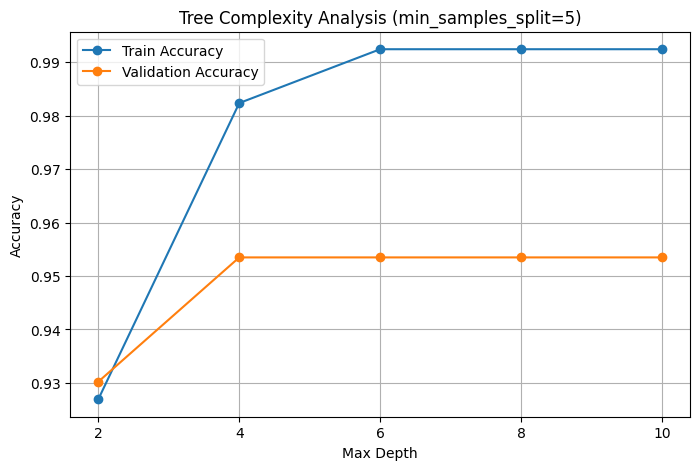


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.982368 0.953488
         6   0.992443 0.953488
         8   0.992443 0.953488
        10   0.992443 0.953488


================ OVERFITTING ANALYSIS ================



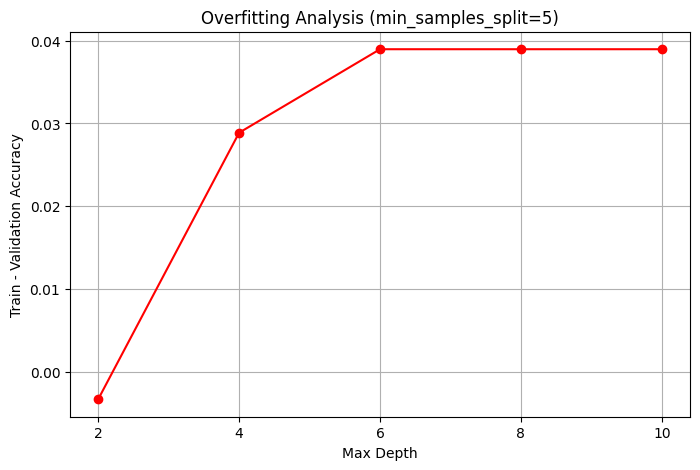


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.982368 0.953488  0.028879
         6   0.992443 0.953488  0.038955
         8   0.992443 0.953488  0.038955
        10   0.992443 0.953488  0.038955

-------------------------------------------------------------
 MODEL: max_depth=4, min_samples_split=10
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.8953

Per-class Metrics:
           Precision   Recall  F1-score
malignant   0.810811  0.93750  0.869565
benign      0.959184  0.87037  0.912621


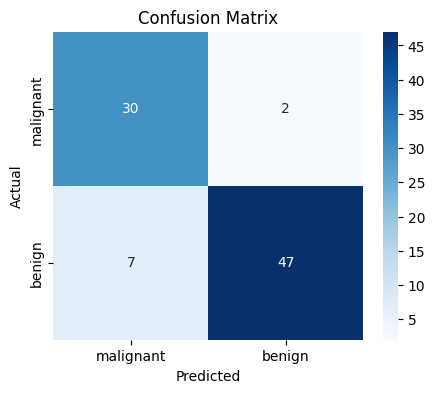



================ FEATURE IMPORTANCE ================

                   Feature  Importance
0          worst perimeter    0.557041
4             worst radius    0.406431
3            worst texture    0.384667
1     worst concave points    0.371103
5  fractal dimension error    0.340467
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



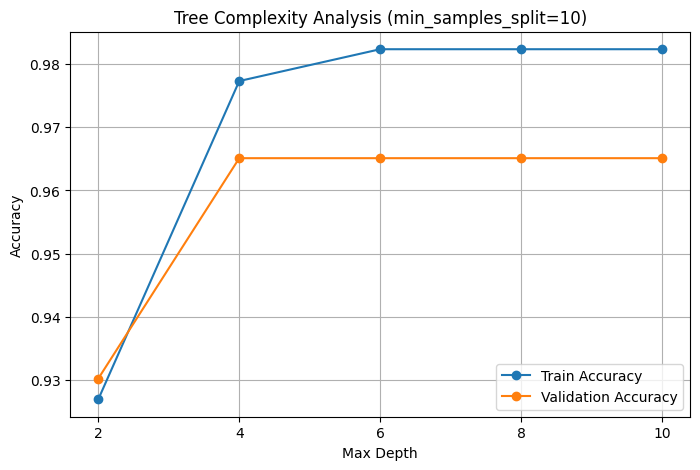


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.977330 0.965116
         6   0.982368 0.965116
         8   0.982368 0.965116
        10   0.982368 0.965116


================ OVERFITTING ANALYSIS ================



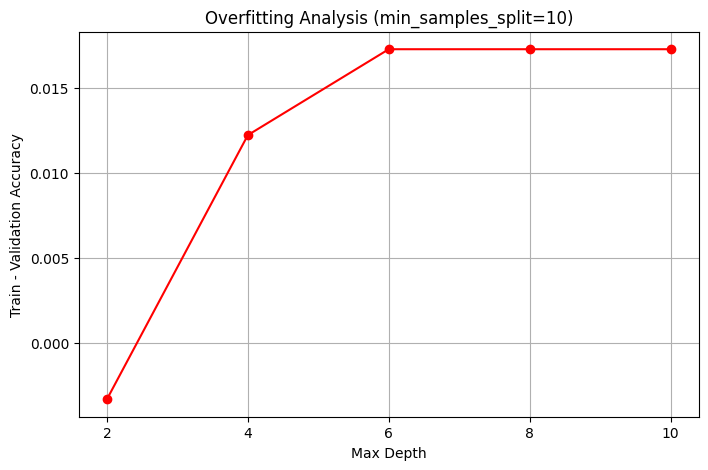


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.977330 0.965116  0.012214
         6   0.982368 0.965116  0.017251
         8   0.982368 0.965116  0.017251
        10   0.982368 0.965116  0.017251

-------------------------------------------------------------
 MODEL: max_depth=6, min_samples_split=2
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.9070

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.833333  0.937500  0.882353
benign      0.960000  0.888889  0.923077


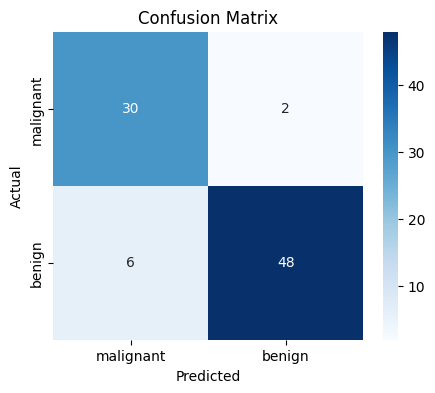



================ FEATURE IMPORTANCE ================

                   Feature  Importance
8              mean radius    1.682500
6         worst smoothness    1.061160
4         mean compactness    1.000000
3            worst texture    0.707424
0          worst perimeter    0.557041
5             worst radius    0.406431
1     worst concave points    0.371103
7  fractal dimension error    0.340467
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



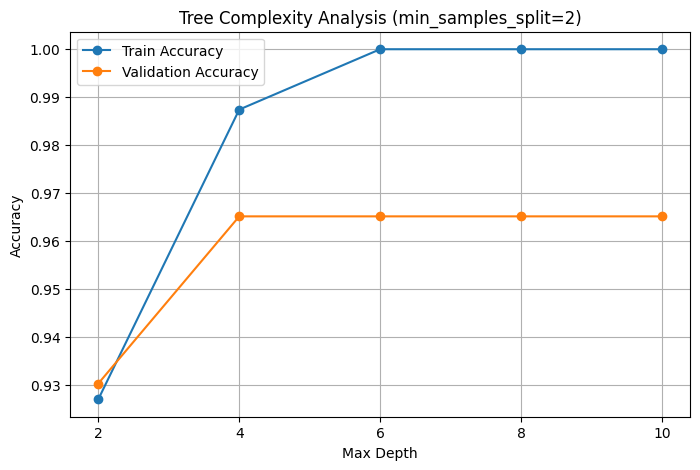


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.987406 0.965116
         6   1.000000 0.965116
         8   1.000000 0.965116
        10   1.000000 0.965116


================ OVERFITTING ANALYSIS ================



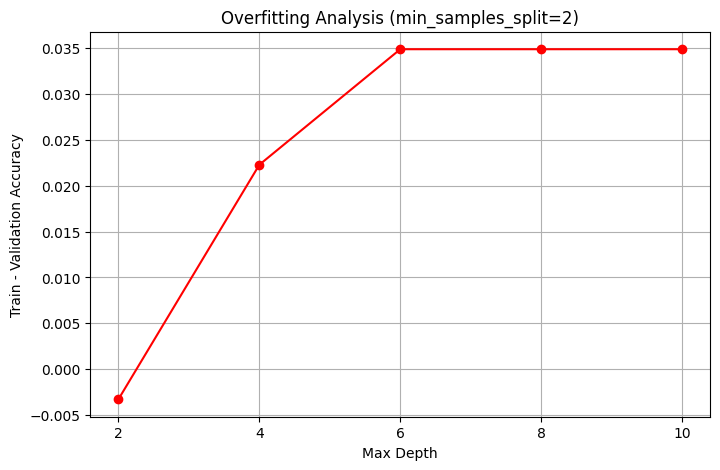


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.987406 0.965116  0.022289
         6   1.000000 0.965116  0.034884
         8   1.000000 0.965116  0.034884
        10   1.000000 0.965116  0.034884

-------------------------------------------------------------
 MODEL: max_depth=6, min_samples_split=5
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.9070

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.833333  0.937500  0.882353
benign      0.960000  0.888889  0.923077


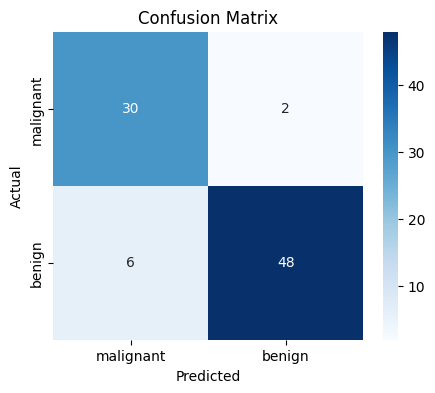



================ FEATURE IMPORTANCE ================

                   Feature  Importance
5         worst smoothness    1.061160
7              mean radius    0.764205
3            worst texture    0.707424
0          worst perimeter    0.557041
4             worst radius    0.406431
1     worst concave points    0.371103
6  fractal dimension error    0.340467
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



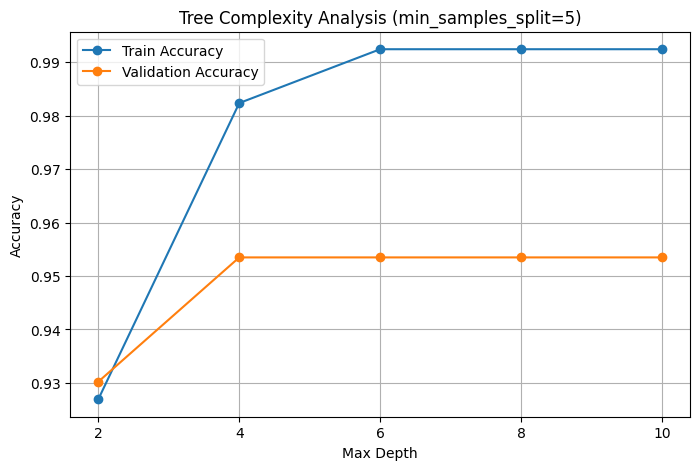


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.982368 0.953488
         6   0.992443 0.953488
         8   0.992443 0.953488
        10   0.992443 0.953488


================ OVERFITTING ANALYSIS ================



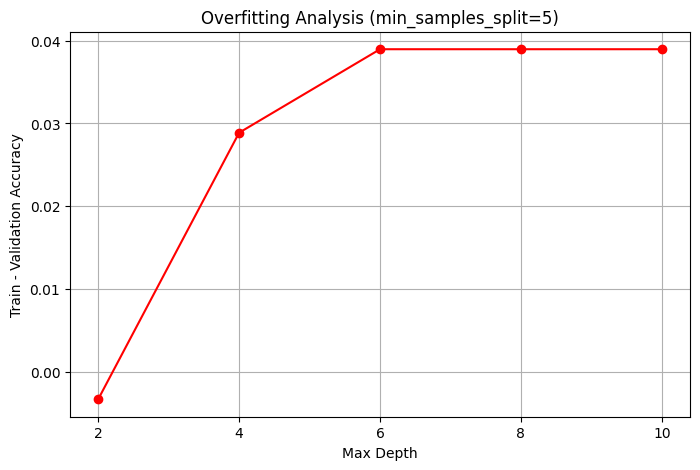


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.982368 0.953488  0.028879
         6   0.992443 0.953488  0.038955
         8   0.992443 0.953488  0.038955
        10   0.992443 0.953488  0.038955

-------------------------------------------------------------
 MODEL: max_depth=6, min_samples_split=10
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.8953

Per-class Metrics:
           Precision   Recall  F1-score
malignant   0.810811  0.93750  0.869565
benign      0.959184  0.87037  0.912621


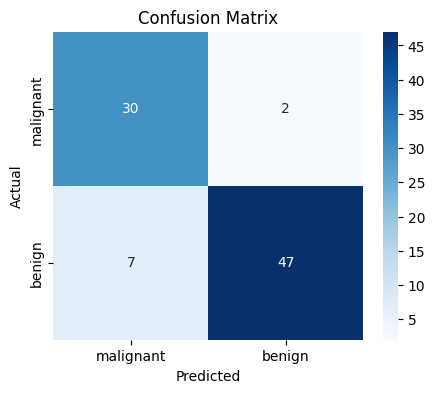



================ FEATURE IMPORTANCE ================

                   Feature  Importance
3            worst texture    0.707424
0          worst perimeter    0.557041
4             worst radius    0.406431
1     worst concave points    0.371103
6  fractal dimension error    0.340467
5         worst smoothness    0.249882
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



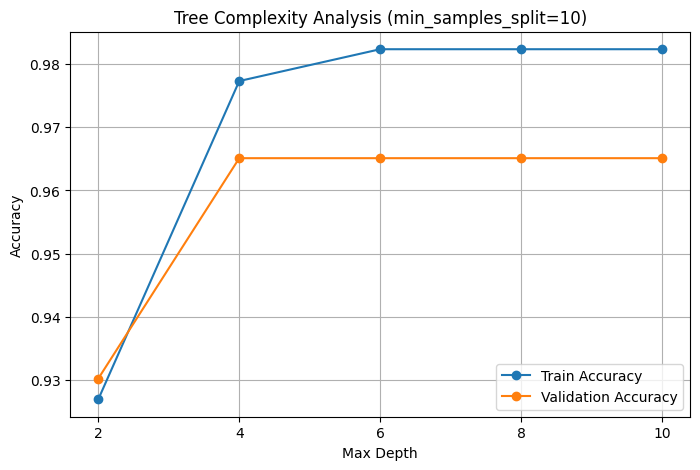


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.977330 0.965116
         6   0.982368 0.965116
         8   0.982368 0.965116
        10   0.982368 0.965116


================ OVERFITTING ANALYSIS ================



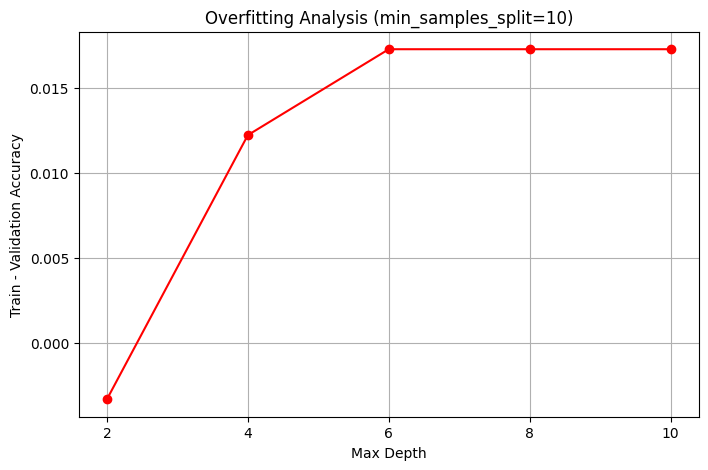


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.977330 0.965116  0.012214
         6   0.982368 0.965116  0.017251
         8   0.982368 0.965116  0.017251
        10   0.982368 0.965116  0.017251

-------------------------------------------------------------
 MODEL: max_depth=8, min_samples_split=2
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.9070

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.833333  0.937500  0.882353
benign      0.960000  0.888889  0.923077


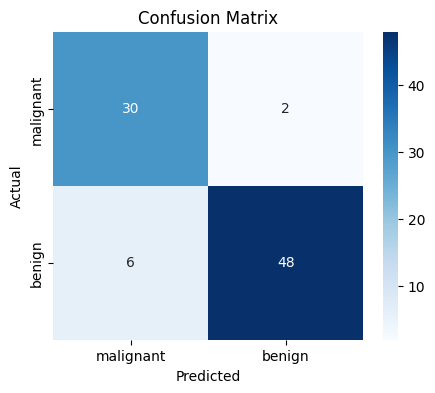



================ FEATURE IMPORTANCE ================

                   Feature  Importance
8              mean radius    1.682500
6         worst smoothness    1.061160
4         mean compactness    1.000000
3            worst texture    0.707424
0          worst perimeter    0.557041
5             worst radius    0.406431
1     worst concave points    0.371103
7  fractal dimension error    0.340467
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



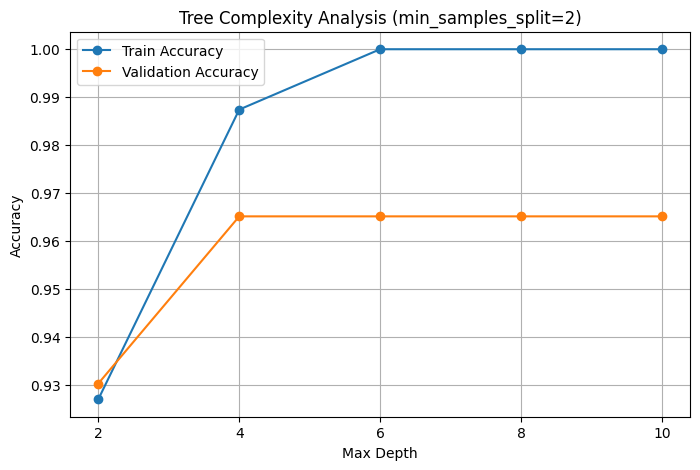


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.987406 0.965116
         6   1.000000 0.965116
         8   1.000000 0.965116
        10   1.000000 0.965116


================ OVERFITTING ANALYSIS ================



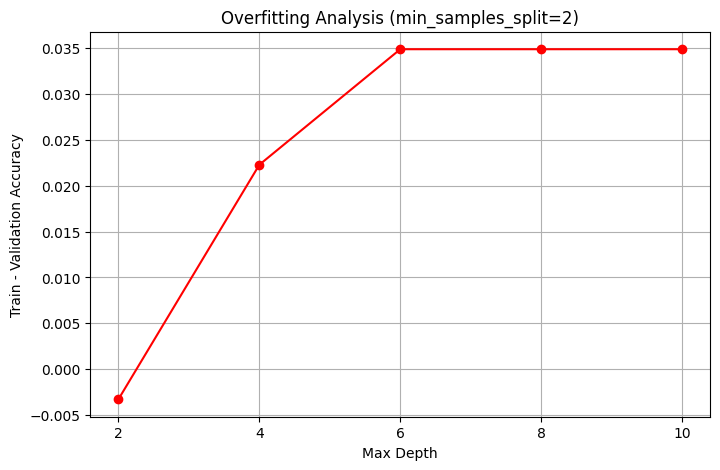


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.987406 0.965116  0.022289
         6   1.000000 0.965116  0.034884
         8   1.000000 0.965116  0.034884
        10   1.000000 0.965116  0.034884

-------------------------------------------------------------
 MODEL: max_depth=8, min_samples_split=5
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.9070

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.833333  0.937500  0.882353
benign      0.960000  0.888889  0.923077


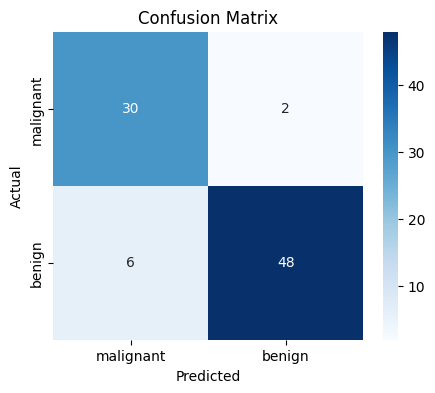



================ FEATURE IMPORTANCE ================

                   Feature  Importance
5         worst smoothness    1.061160
7              mean radius    0.764205
3            worst texture    0.707424
0          worst perimeter    0.557041
4             worst radius    0.406431
1     worst concave points    0.371103
6  fractal dimension error    0.340467
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



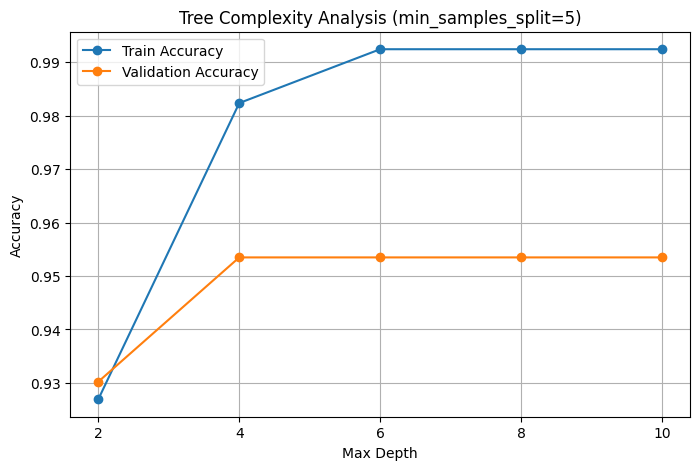


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.982368 0.953488
         6   0.992443 0.953488
         8   0.992443 0.953488
        10   0.992443 0.953488


================ OVERFITTING ANALYSIS ================



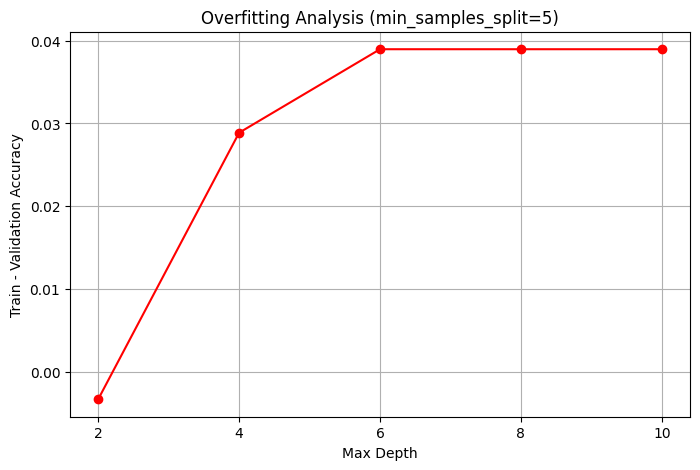


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.982368 0.953488  0.028879
         6   0.992443 0.953488  0.038955
         8   0.992443 0.953488  0.038955
        10   0.992443 0.953488  0.038955

-------------------------------------------------------------
 MODEL: max_depth=8, min_samples_split=10
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.8953

Per-class Metrics:
           Precision   Recall  F1-score
malignant   0.810811  0.93750  0.869565
benign      0.959184  0.87037  0.912621


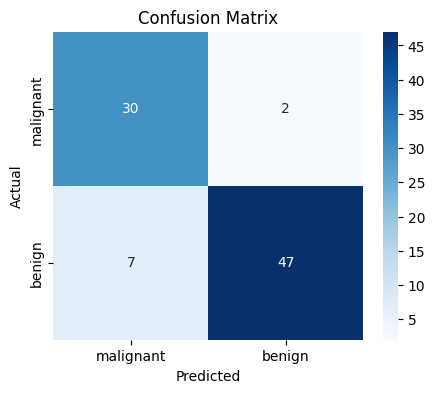



================ FEATURE IMPORTANCE ================

                   Feature  Importance
3            worst texture    0.707424
0          worst perimeter    0.557041
4             worst radius    0.406431
1     worst concave points    0.371103
6  fractal dimension error    0.340467
5         worst smoothness    0.249882
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



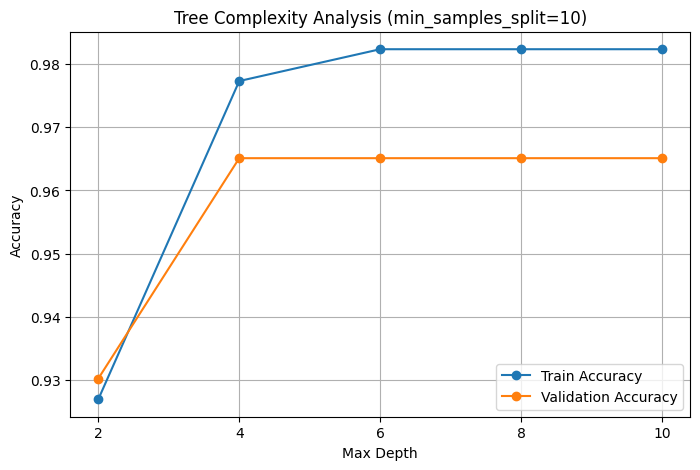


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.977330 0.965116
         6   0.982368 0.965116
         8   0.982368 0.965116
        10   0.982368 0.965116


================ OVERFITTING ANALYSIS ================



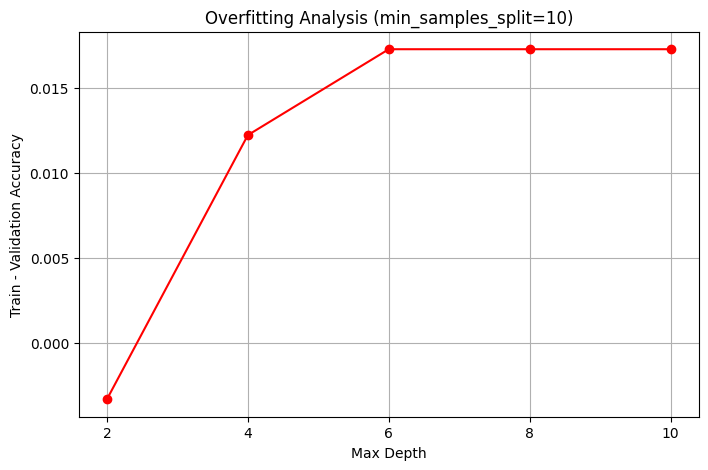


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.977330 0.965116  0.012214
         6   0.982368 0.965116  0.017251
         8   0.982368 0.965116  0.017251
        10   0.982368 0.965116  0.017251

-------------------------------------------------------------
 MODEL: max_depth=10, min_samples_split=2
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.9070

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.833333  0.937500  0.882353
benign      0.960000  0.888889  0.923077


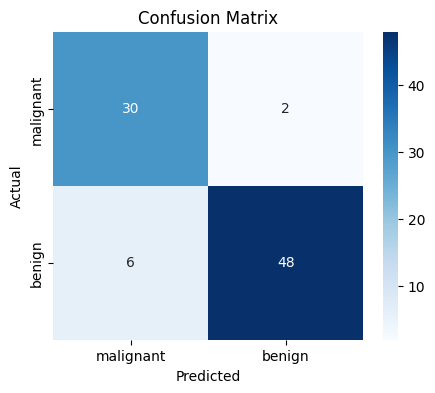



================ FEATURE IMPORTANCE ================

                   Feature  Importance
8              mean radius    1.682500
6         worst smoothness    1.061160
4         mean compactness    1.000000
3            worst texture    0.707424
0          worst perimeter    0.557041
5             worst radius    0.406431
1     worst concave points    0.371103
7  fractal dimension error    0.340467
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



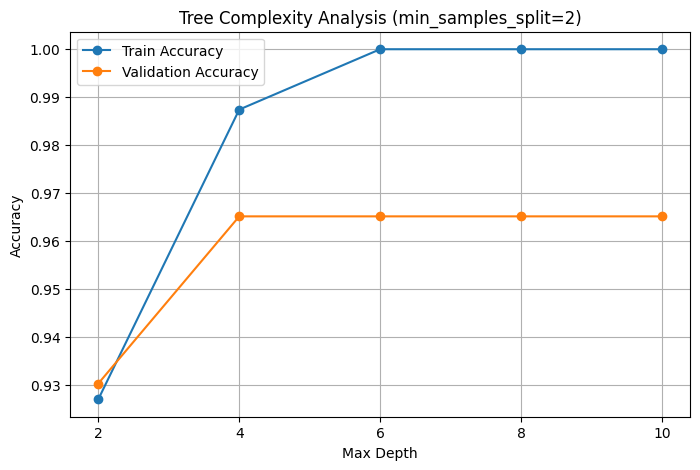


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.987406 0.965116
         6   1.000000 0.965116
         8   1.000000 0.965116
        10   1.000000 0.965116


================ OVERFITTING ANALYSIS ================



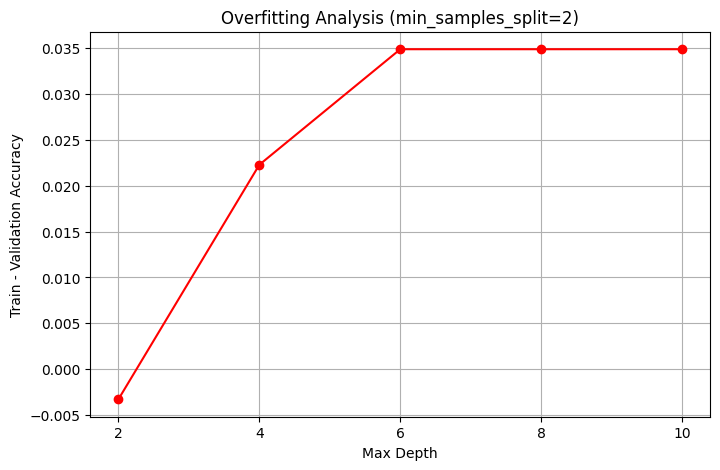


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.987406 0.965116  0.022289
         6   1.000000 0.965116  0.034884
         8   1.000000 0.965116  0.034884
        10   1.000000 0.965116  0.034884

-------------------------------------------------------------
 MODEL: max_depth=10, min_samples_split=5
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.9070

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.833333  0.937500  0.882353
benign      0.960000  0.888889  0.923077


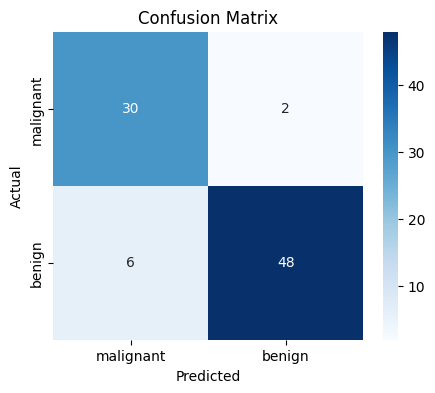



================ FEATURE IMPORTANCE ================

                   Feature  Importance
5         worst smoothness    1.061160
7              mean radius    0.764205
3            worst texture    0.707424
0          worst perimeter    0.557041
4             worst radius    0.406431
1     worst concave points    0.371103
6  fractal dimension error    0.340467
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



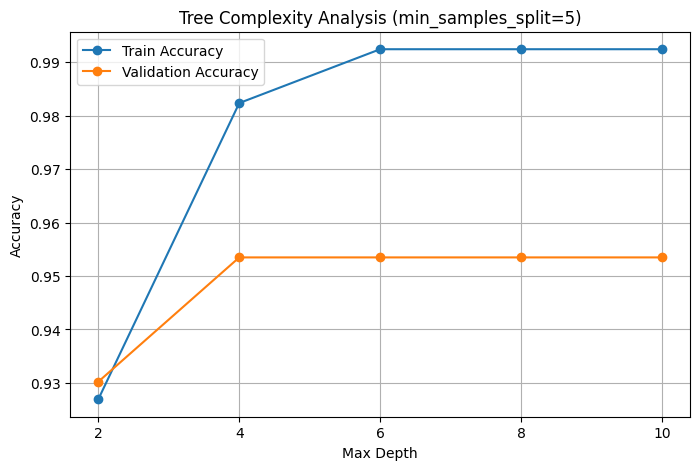


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.982368 0.953488
         6   0.992443 0.953488
         8   0.992443 0.953488
        10   0.992443 0.953488


================ OVERFITTING ANALYSIS ================



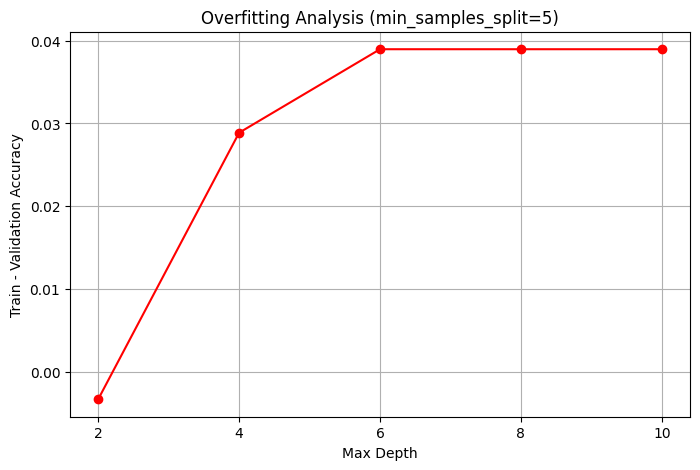


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.982368 0.953488  0.028879
         6   0.992443 0.953488  0.038955
         8   0.992443 0.953488  0.038955
        10   0.992443 0.953488  0.038955

-------------------------------------------------------------
 MODEL: max_depth=10, min_samples_split=10
-------------------------------------------------------------

Test Set Performance

Overall Accuracy: 0.8953

Per-class Metrics:
           Precision   Recall  F1-score
malignant   0.810811  0.93750  0.869565
benign      0.959184  0.87037  0.912621


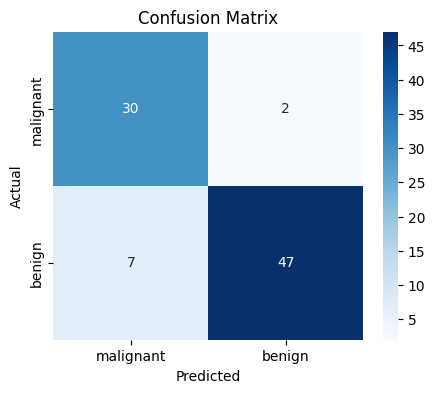



================ FEATURE IMPORTANCE ================

                   Feature  Importance
3            worst texture    0.707424
0          worst perimeter    0.557041
4             worst radius    0.406431
1     worst concave points    0.371103
6  fractal dimension error    0.340467
5         worst smoothness    0.249882
2             radius error    0.043643


================ TREE COMPLEXITY ANALYSIS ================



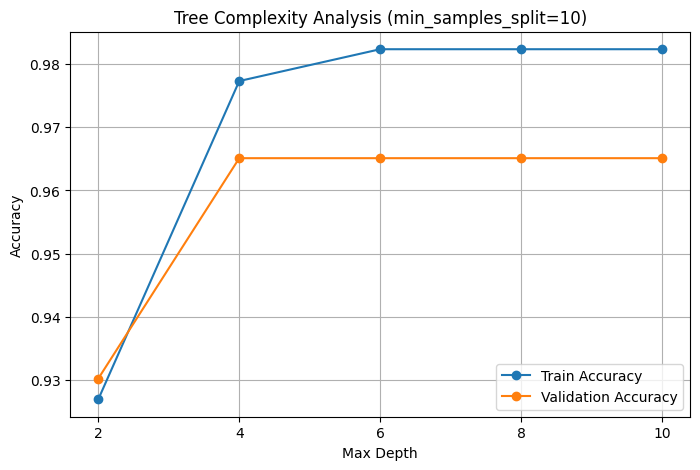


Summary Table:
 max_depth  train_acc  val_acc
         2   0.926952 0.930233
         4   0.977330 0.965116
         6   0.982368 0.965116
         8   0.982368 0.965116
        10   0.982368 0.965116


================ OVERFITTING ANALYSIS ================



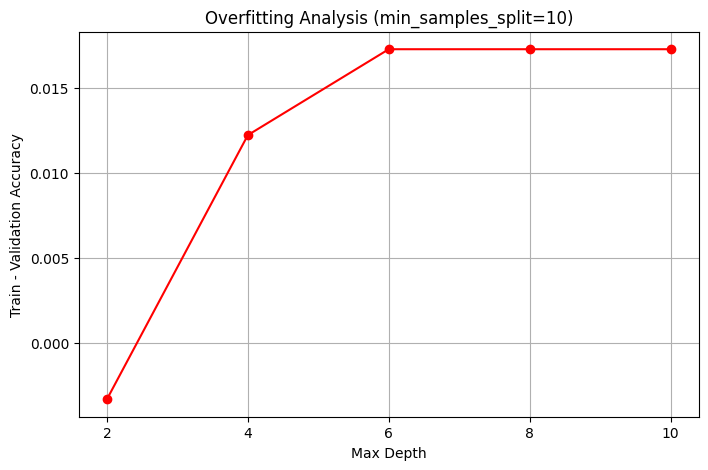


Overfitting Gap (Train - Validation Accuracy):
 max_depth  train_acc  val_acc       gap
         2   0.926952 0.930233 -0.003280
         4   0.977330 0.965116  0.012214
         6   0.982368 0.965116  0.017251
         8   0.982368 0.965116  0.017251
        10   0.982368 0.965116  0.017251

================ END OF FULL EVALUATION ================



In [10]:
# Analysis and Final Evaluation
run_full_evaluation(
    models,
    X_test,
    y_test,
    feature_names,
    target_names,
    results_df
)

## Ensemble Method - Random Forest 

In [18]:
# Random Forest 
T = [5 , 10, 30, 50]
d = X_train.shape[1]
max_feats = [int(np.floor(np.sqrt(d))) , int(d/2)]

best_T = None
best_max_features = None

for t in T:
    for m in max_feats:
        rf = RandomForest(n_trees=t, max_features=m, max_depth=best_max_depth, min_samples_split=best_min_samples_split)
        
        rf.fit(X_train, y_train)

        val_preds = rf.predict(X_val)
        rf.metrics = compute_metrics(y_val, val_preds, class_names=target_classes)
        print(f"Random Forest with T={t}, max_features={m} => Validation Accuracy: {rf.metrics['accuracy']*100:.4f}")
        if best_T is None or rf.metrics['accuracy'] > best_rf.metrics['accuracy']:
            best_rf = rf
            best_T = t
            best_max_features = m
    print("="*10)

print()
print(f"Best Random Forest hyperparameters: T={best_T}, max_features={best_max_features} with Validation Accuracy: {best_rf.metrics['accuracy']*100:.4f}")

Random Forest with T=5, max_features=5 => Validation Accuracy: 95.3488
Random Forest with T=5, max_features=15 => Validation Accuracy: 96.5116
Random Forest with T=10, max_features=5 => Validation Accuracy: 97.6744
Random Forest with T=10, max_features=15 => Validation Accuracy: 97.6744
Random Forest with T=30, max_features=5 => Validation Accuracy: 98.8372
Random Forest with T=30, max_features=15 => Validation Accuracy: 96.5116
Random Forest with T=50, max_features=5 => Validation Accuracy: 97.6744
Random Forest with T=50, max_features=15 => Validation Accuracy: 96.5116

Best Random Forest hyperparameters: T=30, max_features=5 with Validation Accuracy: 98.8372


## Retraining training+validation

Test Set Performance

Overall Accuracy: 0.9419

Per-class Metrics:
           Precision    Recall  F1-score
malignant   0.909091  0.937500  0.923077
benign      0.962264  0.944444  0.953271


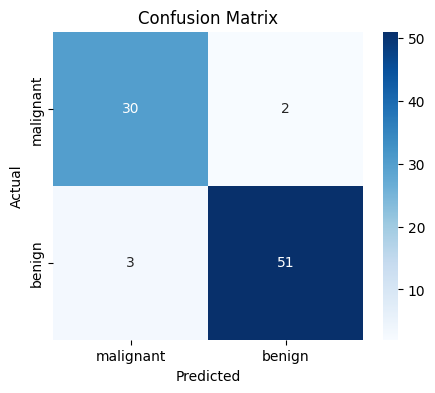

In [24]:
# Retrain on train + validation
X_train_val = np.vstack([X_train, X_val])
y_train_val = np.hstack([y_train, y_val])

best_rf = RandomForest(n_trees=best_T, max_features=best_max_features, max_depth=best_max_depth, min_samples_split=best_min_samples_split)

best_rf.fit(X_train_val, y_train_val)
y_test_preds = best_rf.predict(X_test)
y_test_metrics = compute_metrics(y_test, y_test_preds, class_names=target_classes)
fr_metrics = evaluate_tree(best_rf, X_test, y_test, class_names=target_classes)


## Best Decision tree vs Best Random Forest

=== Model Comparison: Decision Tree vs Random Forest ===

Metric         Decision Tree       Random Forest       
-------------------------------------------------------
Accuracy       94.19               94.19               

Class: malignant
Precision      86.49               90.91               
Recall         100.00              93.75               
F1-Score       92.75               92.31               

Class: benign
Precision      100.00              96.23               
Recall         90.74               94.44               
F1-Score       95.15               95.33               


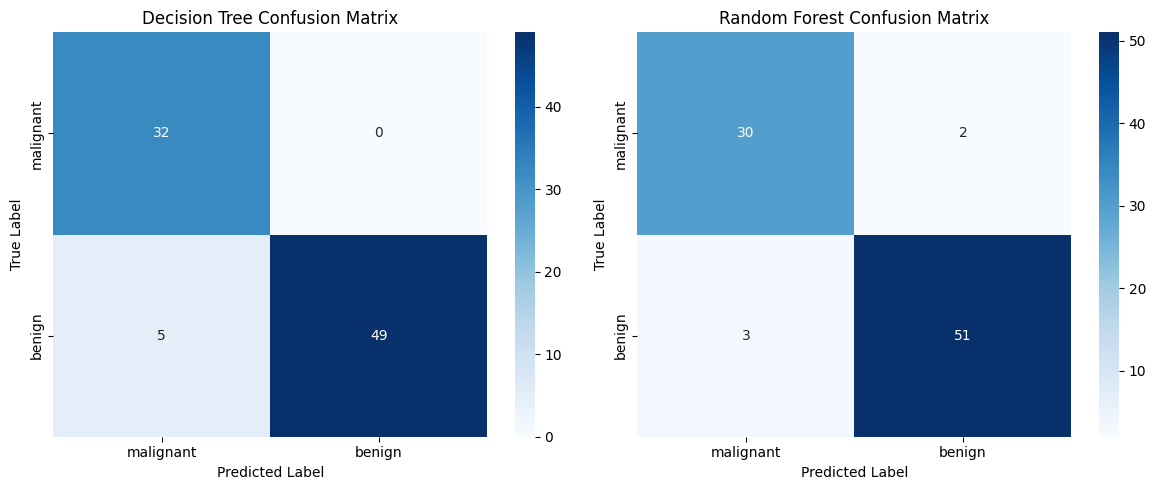

In [27]:
# best_tree => metrics
# best_rf => fr_metrics

print("=== Model Comparison: Decision Tree vs Random Forest ===\n")
print(f"{'Metric':<15}{'Decision Tree':<20}{'Random Forest':<20}")
print("-"*55)

# Overall accuracy
print(f"{'Accuracy':<15}{metrics['accuracy']*100:<20.2f}{fr_metrics['accuracy']*100:<20.2f}")

# Per-class metrics
for cls in target_classes:
    print(f"\nClass: {cls}")
    print(f"{'Precision':<15}{metrics['precision'][cls]*100:<20.2f}{fr_metrics['precision'][cls]*100:<20.2f}")
    print(f"{'Recall':<15}{metrics['recall'][cls]*100:<20.2f}{fr_metrics['recall'][cls]*100:<20.2f}")
    print(f"{'F1-Score':<15}{metrics['f1'][cls]*100:<20.2f}{fr_metrics['f1'][cls]*100:<20.2f}")


plt.figure(figsize=(12,5))

# Decision Tree Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

# Random Forest Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(fr_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

plt.tight_layout()
plt.show()


#### Effect on Bias and Variance

Single Decision Tree: low bias but high variance; predictions can vary greatly with small changes in training data, leading to overfitting.

Random Forest: maintains low bias while greatly reducing variance through bootstrap sampling and random feature selection; predictions are more stable and generalize better.